In [1]:
### run the script from the figures_code directory

import sys
os.chdir('../')
import seaborn as sns
import re
from functions import lib_table_operations as lto
from functions import data_processing as dp
from functions import params


In [3]:
all_tf_coop = params.ALL_TF_COOP

## (A) Sok2 cooperativity scores

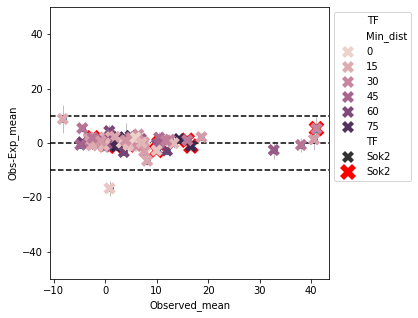

In [6]:
tf = 'Sok2'
tf_split =  re.findall('\d*\D+',tf)[0]
tf_data = all_tf_coop.query("TF==@tf")
fig,ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data=tf_data, x='Observed_mean', y='Obs-Exp_mean', hue='Min_dist',style='TF', markers=['X'],  s=150, zorder=20, linewidth=0, ax=ax)
plt.errorbar(tf_data['Observed_mean'], tf_data['Obs-Exp_mean'], yerr=tf_data['Obs-Exp_sem'],
             ecolor='grey',elinewidth=0.5, fmt='o')
self_df = tf_data.query("Comb_type=='Self_comb'")
sns.scatterplot(data=self_df, x='Observed_mean', y='Obs-Exp_mean', color='r',style='TF', markers='X', s=250, linewidth=0, ax=ax)
ax.set_ylim(-50,50)
ax.axline((0,0), slope=0, color='k', linestyle='--')
ax.axline((0,10), slope=0, color='k', linestyle='--')
ax.axline((0,-10), slope=0, color='k', linestyle='--')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## (B) Cooperation and inhibition examples for Msn2

/home/labs/barkailab/tamarj/TF_combinatorics/MPBA/functions/data_processing.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  info['gene_id'] = params.GENE_NAMES.index(info['gene'].upper())  # getting the gene ID (based on GP)
/home/labs/barkailab/tamarj/TF_combinatorics/MPBA/functions/data_processing.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  info['gene_id'] = params.GENE_NAMES.index(info['gene'].upper())  # getting the gene ID (based on GP)


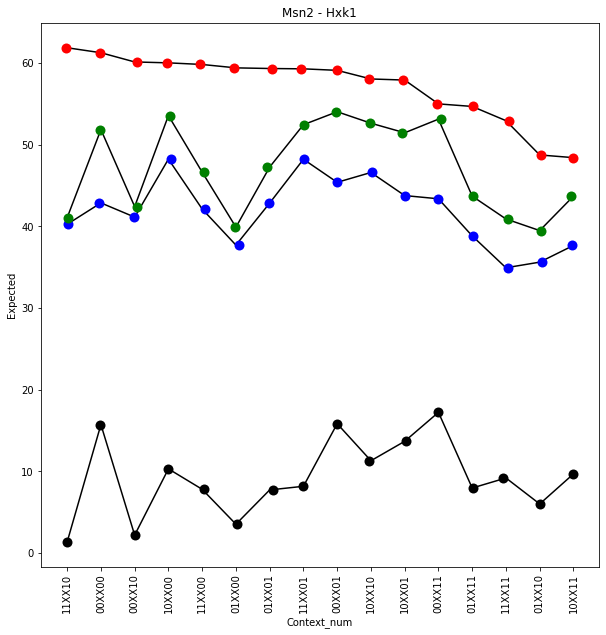

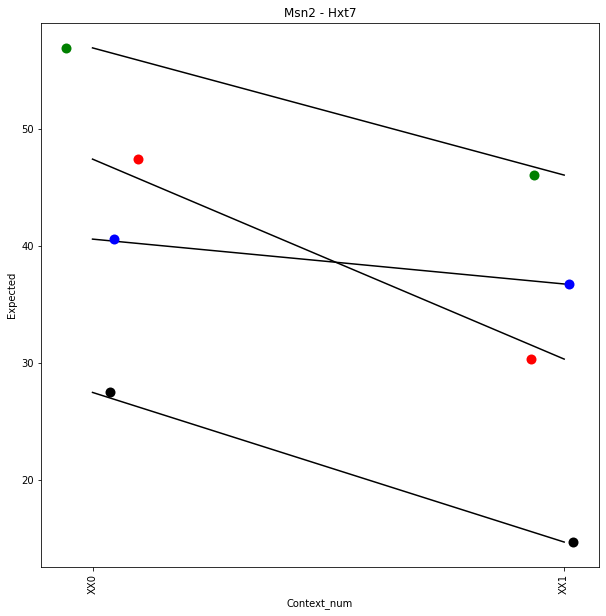

In [2]:
tf = 'Msn2'
libs = ['87','86']
exp = '13'
combs = [[2,3],[0,1]]
tp = '180'

for i in range(len(libs)):
    
    lib_num = libs[i]
    comb = combs[i]
    
    comb_df = lto.comb_opts_by_context(tf,lib_num,exp, comb, tp)
    
    comb_df_norm = comb_df.iloc[:,0:3] - comb_df.iloc[:,3].to_frame().values
    comb_df_norm['Context'] = comb_df['Context'] 
    comb_df = comb_df_norm
    
    
    comb_df_expected = comb_df.copy()
    comb_df_rel =  comb_df[['++','+-','-+']]
    comb_df_rel = lto.convert_fc_to_occ(comb_df_rel)
    comb_df_rel['Expected'] = 1-((1-comb_df_rel['+-'])*(1-comb_df_rel['-+']))
    comb_df_rel = comb_df_rel*100

    lib_info = dp.get_lib_info(lib_num)
    wt_var_seq = lib_info['wt_at_var_loc']  # get wild-type sequence
    context_nums = []
    for seq in comb_df['Context'].values:
        seq = list(seq)
        seq.insert(comb[0], 'X')
        seq.insert(comb[1], 'X')
        seq = np.array(seq)
        for i,nuc in enumerate(seq):
            if nuc == wt_var_seq[i]:
                seq[i] = '1'
            elif nuc == 'X':
                continue
            else:
                seq[i] = '0'

        context_nums.append(''.join(seq))
    comb_df_rel['Context_num'] = context_nums

    opts_dots = ['++', '+-', '-+','Expected']

    comb_df_rel.sort_values(by='++', ascending=False, inplace=True)
    cols = ['r','b','k','g']
    comb_df_rel.sort_values(by='++')
    comb_df_rel.reset_index(drop=True, inplace=True)
    figure, ax = plt.subplots(1,1,figsize=(10,10))
    axes = []
    for i, opt in enumerate(opts_dots):
        curr_ax = sns.stripplot(data=comb_df_rel, x='Context_num', y=opt, color=cols[i],s=10, ax=ax)
        sns.lineplot(data=comb_df_rel, x=comb_df_rel.index, y=opt, color='k', ax=ax)
        axes.append(curr_ax)
    plt.xticks(rotation = 90)
    ax.set_title(tf +' - '+ lib_info['gene'])


## (C) Msn2 cooperativity scores - time course

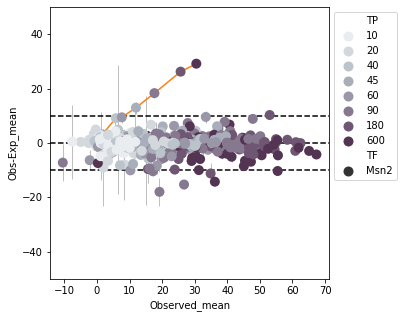

In [7]:
curr_tf = 'Msn2'
relevant_exps = ['25', '13', '26']

tf_files = dp.find_tf_files(curr_tf)
lib_nums = list(set([file.split('.')[0].split('_')[1] for file in tf_files]))
Msn2_coop_tps = pd.DataFrame()

for curr_lib_num in lib_nums:
    lib_info = dp.get_lib_info(curr_lib_num)       
    lib_files = [ i.split('.')[0] for i in tf_files if i.split('.')[0].split('_')[1]==str(curr_lib_num)]
    tf_lib_exps = np.intersect1d([i.split('_')[2] for i in lib_files], relevant_exps)

    exp_tps = {}
    for file in lib_files:
        curr_exp = file.split('_')[2]
        x, _ = lto.only_pos_intact_change_calc(curr_tf, curr_lib_num,exp_num=curr_exp, norm_to=None,occ=None,norm_df=None)
        exp_tps[curr_exp] = x.index
    if len(lib_files)> 1:
        overlapping_tps = np.intersect1d(list(exp_tps.values())[0], list(exp_tps.values())[1])
    else:
        overlapping_tps = list(exp_tps.values())[0]

    for file in lib_files:
        curr_exp = file.split('_')[2]
        for tp in exp_tps[curr_exp]:
            if tp in overlapping_tps:
                res_data = dp.mean_over_bio_reps(lto.combine_2_exps(curr_tf, curr_lib_num, tp, list(tf_lib_exps), norm_to=None))
            else:
                res_data = dp.mean_over_bio_reps(lto.combine_2_exps(curr_tf, curr_lib_num, tp, [curr_exp], norm_to=None))

            curr_lib_data = lto.obs_exp_mean_context(curr_tf, curr_lib_num, tp, [curr_tf], norm_df=res_data)
            curr_lib_data['TP'] = np.repeat(tp, len(curr_lib_data))
            Msn2_coop_tps = pd.concat([Msn2_coop_tps, curr_lib_data])
Msn2_coop_tps.drop_duplicates(inplace=True)

fig,ax = plt.subplots(1,1,figsize=(5,5))
color_palette = sns.color_palette("BuPu", len(Msn2_coop_tps['TP'].unique()), desat=.3)

hue_order = np.sort(Msn2_coop_tps['TP'].unique().astype(int)).astype(str)

sns.scatterplot(data=Msn2_coop_tps, x='Observed_mean', y='Obs-Exp_mean',markers={'Msn2':'o', 'Sok2':'X'},
                hue='TP', hue_order=hue_order, palette=color_palette, s=100, style='TF',  linewidth=0,  zorder=20, ax=ax)
plt.errorbar(Msn2_coop_tps['Observed_mean'], Msn2_coop_tps['Obs-Exp_mean'], yerr=Msn2_coop_tps['Obs-Exp_sem'],
             ecolor='grey',elinewidth=0.5, fmt='o')

cont = Msn2_coop_tps.query("Gene=='Usv1' & Comb=='0_1'").reset_index(drop=True)
sns.lineplot(data=cont, x='Observed_mean', y='Obs-Exp_mean')
ax.set_ylim(-50,50)
ax.axline((0,0), slope=0, color='k', linestyle='--')
ax.axline((0,10), slope=0, color='k', linestyle='--')
ax.axline((0,-10), slope=0, color='k', linestyle='--')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))